In [17]:
import numpy as np
import torch
import scipy.io
import matplotlib.pyplot as plt
from timeit import default_timer
from utilities3 import *

from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.optim import Adam
import pickle

from scipy.io import savemat

#from train_utils.datasets import MatReader
#from train_utils.losses import LpLoss
#from train_utils.utils import count_params
from scipy import io
torch.manual_seed(0)
np.random.seed(0)

def set_seed(seed):    
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
set_seed(0)
import sys

class FNN(nn.Module):
    """Fully-connected neural network."""

    def __init__(self, layer_sizes):
        super(FNN, self).__init__()

        layers = []
        for i in range(1, len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i - 1], out_features=layer_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=layer_sizes[-2], out_features=layer_sizes[-1]))

        self.denses = nn.ModuleList(layers)

    def forward(self, inputs):
        y = inputs
        for f in self.denses:
            y = f(y)
        return y
    
class DeepONet(nn.Module):
    def __init__(self, layer_size_branch,layer_size_trunk):
        super(DeepONet, self).__init__()

        self.layer_size_branch = layer_size_branch
        #self.layer_size_bc = layer_size_bc
        self.layer_size_trunk = layer_size_trunk
        
        #self.b1=nn.Linear(3, 1)
        #self.b2=nn.Linear(3, 1)
        

        self.branch_net = FNN(self.layer_size_branch)
        self.trunk_net = FNN(self.layer_size_trunk)

        self.bias_last = nn.Parameter(torch.zeros(1), requires_grad=True)

    def forward(self, x_branch,x_trunk):

        y_branch = self.branch_net(x_branch)
       
     
        y_trunk = self.trunk_net(x_trunk)
        
        Y = torch.einsum("bi,bni->bn", y_branch, y_trunk)
        Y += self.bias_last
        return Y

    
    
################################################################
# configs
################################################################

ntrain = 500
ntest = 100

batch_size = 20
learning_rate= 0.0001
epochs = 5000


################################################################
# load data and data normalization
################################################################
u_all = scipy.io.loadmat('u_all.mat')['u_all']
f_all = scipy.io.loadmat('f_all.mat')['f_all']
xy_all = scipy.io.loadmat('xy_all.mat')['xy_all']
N_xy=51*51

u_all=u_all.reshape(600,N_xy)
f_all=f_all.reshape(600,N_xy)

input_u = torch.tensor(u_all, dtype=torch.float32)
input_f = torch.tensor(f_all, dtype=torch.float32)
input_xy= torch.tensor(xy_all, dtype=torch.float32)

train_f = input_f[:ntrain]
test_f = input_f[-ntest:]
train_u = input_u[:ntrain]
test_u = input_u[-ntest:]
train_xy = input_xy[:ntrain]
test_xy = input_xy[-ntest:]


print(train_f.shape, train_u.shape, train_xy.shape)

layer_size_branch=[N_xy,256,256,256,64]
layer_size_trunk=[2,256,256,256,64]

model = DeepONet(layer_size_branch,layer_size_trunk).cuda()
print(count_params(model))
model = torch.load('possion').cuda()

torch.Size([500, 2601]) torch.Size([500, 2601]) torch.Size([500, 2601, 2])
962945


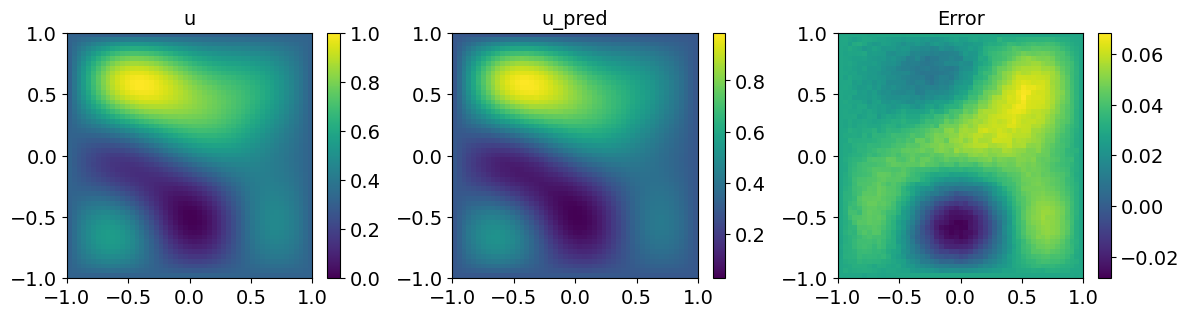

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n=45
f=test_f[n,:].reshape(1,N_xy).to(device)
u=test_u[n,:]
xy=test_xy[n,:,:].reshape(1,N_xy,2).to(device)
out = model(f,xy)

u_pred=out.squeeze().detach().cpu().numpy()
u_pred=u_pred.reshape(51,51)
u=u.reshape(51,51)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, data, title in zip(axes, [u, u_pred, u-u_pred], ['u', 'u_pred', 'Error']):
    im = ax.imshow(data, cmap='viridis', extent=[-1, 1, -1, 1])
    ax.set_title(title, fontsize=14)  # 设置标题字号
    ax.tick_params(labelsize=14)      # 设置坐标轴刻度字号

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=14)  # 设置 colorbar 刻度字号

plt.tight_layout()
plt.savefig('deeponet.eps', format='eps')
plt.show()

torch.Size([1, 2601, 2])
(2601, 64) (64, 2601)


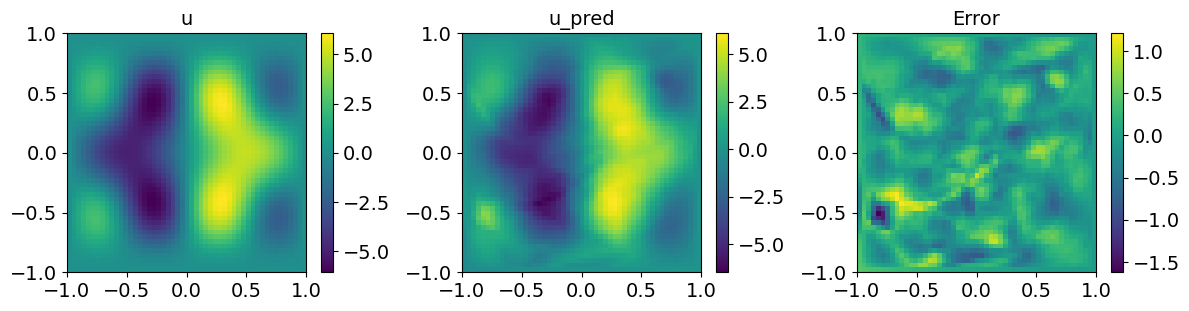

In [20]:
from scipy import io
from scipy.interpolate import griddata

n = 51  # 分辨率
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)
x_flat = X.ravel()
y_flat = Y.ravel()
coords = np.stack([x_flat, y_flat], axis=1).reshape(1, n**2, 2)

p = torch.tensor(coords,dtype=torch.float).to(device)
print(p.shape)
N=p.shape[0]
p=p.reshape(1,n**2,2)
P = model.trunk_net(p)
P=P.reshape(n**2,64)
R=P.T
P=P.detach().cpu().numpy()
R=R.detach().cpu().numpy()
print(P.shape,R.shape)

u = test_u[n, :].reshape(-1, 1)  # u shape: (2601, 1)


# 随机系数
a1 = 2.5
a2 = 2

# 假设 X, Y 是网格坐标
u = a1 * np.sin(np.pi * x_flat) * (1 + np.cos(np.pi * y_flat)) + \
    a2 * np.sin(2 * np.pi * x_flat) * (1 - np.cos(2 * np.pi * y_flat))


u = torch.tensor(u, dtype=torch.float).to(device)

# P 需要是 torch tensor（前面已经转成 numpy 了，需要转回来）
P = torch.tensor(P, dtype=torch.float).to(device)  # shape: (2601, 64)

# 最小二乘投影: u_proj = P (P^T P)^{-1} P^T u
PtP_inv = torch.inverse(P.T @ P)            # (64, 64)
u_proj = P @ (PtP_inv @ (P.T @ u))          # (2601, 1)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
u = u.detach().cpu().numpy().reshape(n, n)
u_proj = u_proj.detach().cpu().numpy().reshape(n, n)

for ax, data, title in zip(axes, [u, u_proj, u-u_proj], ['u', 'u_pred', 'Error']):
    im = ax.imshow(data, cmap='viridis', extent=[-1, 1, -1, 1])
    ax.set_title(title, fontsize=14)  # 设置标题字号
    ax.tick_params(labelsize=14)      # 设置坐标轴刻度字号

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=14)  # 设置 colorbar 刻度字号

plt.tight_layout()
plt.show()